In [1]:
import sys
sys.path.append("../")
from pathlib import Path

DIR = Path("/data1/xp/code/specEmbedding/score_distribution/pair/")

import torch
import numpy as np

from train import ModelTester
from const import gnps
from data import Tokenizer
from utils import embedding, load_transformer_model

In [2]:
show_progress_bar = False
is_augment = True
model_backbone = "transformer"
loss_type = "SupConWithTanimotoLoss"
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
tokenizer = Tokenizer(100, show_progress_bar)
model = load_transformer_model(device, loss_type, is_augment)
tester = ModelTester(model, device, show_progress_bar)

In [3]:
from utils import cosine_similarity

spectra = np.load(gnps.ORBITRAP_TEST_QUERY, allow_pickle=True)

spectra_embedding, _ = embedding(
    tester, tokenizer,
    512, spectra,
    False
)

cosine_scores = cosine_similarity(spectra_embedding, spectra_embedding)
mask = np.diag(np.ones((cosine_scores.shape[0]))).astype(bool)
mask = ~mask
cosine_scores = cosine_scores[mask]
np.save("/data1/xp/code/specEmbedding/score_distribution/tanimoto/SpecEmbedding.npy", cosine_scores.flatten())

In [4]:
query = np.load(gnps.ORBITRAP_TEST_QUERY, allow_pickle=True)
ref = np.load(gnps.ORBITRAP_TEST_REF, allow_pickle=True)

query_embedding, query_smiles = embedding(
    tester, tokenizer,
    512, query,
    False
)

ref_embedding, ref_smiles = embedding(
    tester, tokenizer,
    512, ref,
    False
)

cosine_scores = cosine_similarity(query_embedding, ref_embedding)

positive_indices = np.load(DIR / "positive_indices.npy", allow_pickle=True).item()
negative_indices = np.load(DIR / "negative_indices.npy", allow_pickle=True).item()

data = {
    "positive": cosine_scores[positive_indices["row"], positive_indices["col"]],
    "negative": cosine_scores[negative_indices["row"], negative_indices["col"]]
}

np.save(DIR / "SpecEmbedding.npy", data)

In [5]:
data["positive"].shape, data["negative"].shape

((32079,), (32079,))

<Axes: ylabel='Density'>

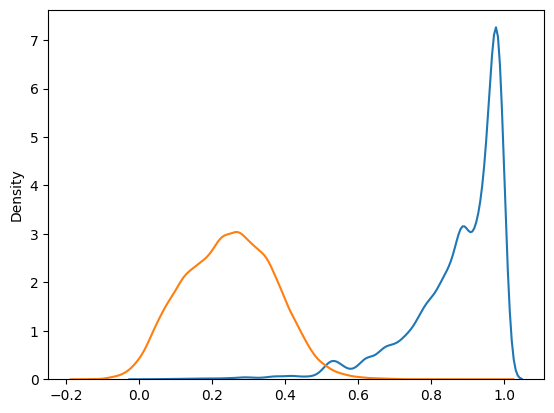

In [6]:
import seaborn as sns

sns.kdeplot(data["positive"])
sns.kdeplot(data["negative"])